In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import os
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-11-04 11:35:25.246156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-04 11:35:25.267425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-04 11:35:25.273919: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-04 11:35:25.290034: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Dataset shape: (10015, 7)

First few rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


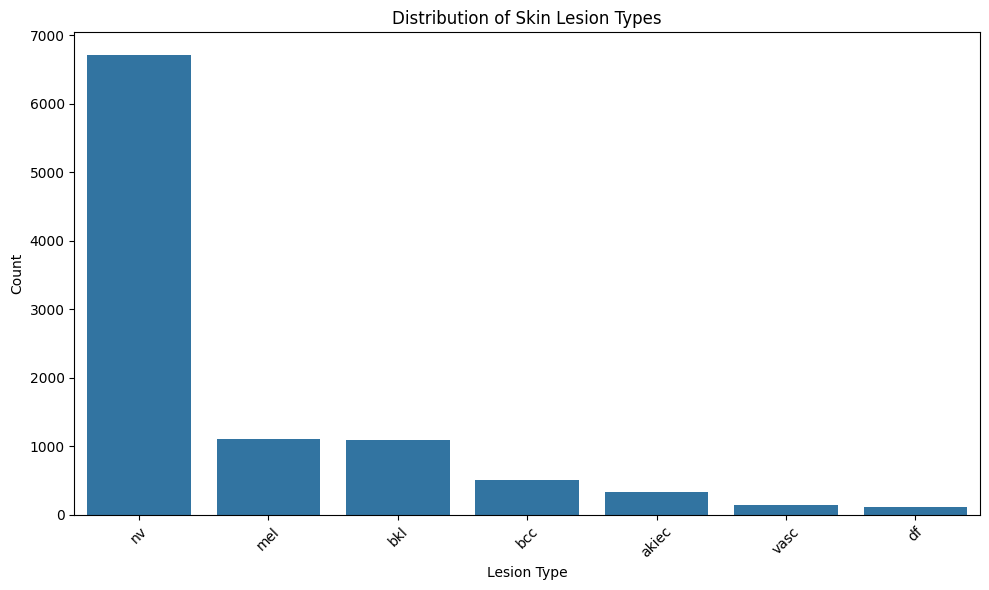

In [2]:

# Load metadata
# Adjust paths according to your directory structure
metadata_path = 'dataset/archive/HAM10000_metadata.csv'
images_path_1 = 'dataset/archive/HAM10000_images_part_1/'
images_path_2 = 'dataset/archive/HAM10000_images_part_2/'

df = pd.read_csv(metadata_path)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nClass distribution:")
print(df['dx'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dx', order=df['dx'].value_counts().index)
plt.title('Distribution of Skin Lesion Types')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Class mapping
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [3]:
print("\n=== DATA BALANCING ===")
print("Original class distribution:")
print(df['dx'].value_counts())

# Calculate class weights for handling imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df['dx']),
    y=df['dx']
)

class_weight_dict = dict(enumerate(class_weights))
print("\nClass weights:", class_weight_dict)

# Optional: Oversample minority classes
from sklearn.utils import resample

# Find the maximum class count
max_count = df['dx'].value_counts().max()

# Oversample each class to match the maximum
df_balanced = pd.DataFrame()

for lesion_class in df['dx'].unique():
    df_class = df[df['dx'] == lesion_class]
    df_class_oversampled = resample(df_class, 
                                     replace=True,
                                     n_samples=max_count,
                                     random_state=42)
    df_balanced = pd.concat([df_balanced, df_class_oversampled])

df_balanced = df_balanced.reset_index(drop=True)

print("\nBalanced class distribution:")
print(df_balanced['dx'].value_counts())




=== DATA BALANCING ===
Original class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Class weights: {0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}

Balanced class distribution:
dx
bkl      6705
nv       6705
df       6705
mel      6705
vasc     6705
bcc      6705
akiec    6705
Name: count, dtype: int64


DATA PREPROCESSING

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Create image paths
def get_image_path(image_id):
    path1 = os.path.join(images_path_1, image_id + '.jpg')
    path2 = os.path.join(images_path_2, image_id + '.jpg')
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    return None

df_balanced['image_path'] = df_balanced['image_id'].apply(get_image_path)

# Remove rows where image path is None
df_balanced = df_balanced[df_balanced['image_path'].notna()]

print(f"\nTotal images available: {len(df_balanced)}")

# Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['dx'])

print("\nLabel encoding:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name} - {lesion_type_dict[class_name]}")



Total images available: 46935

Label encoding:
0: akiec - Actinic keratoses
1: bcc - Basal cell carcinoma
2: bkl - Benign keratosis-like lesions
3: df - Dermatofibroma
4: mel - Melanoma
5: nv - Melanocytic nevi
6: vasc - Vascular lesions


In [5]:
print("\n=== DATA SPLITTING ===")

# Split into train (70%), validation (15%), and test (15%)
X = df_balanced['image_path'].values
y = df_balanced['label'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 of 0.85 ≈ 0.15
)

print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")




=== DATA SPLITTING ===
Training set: 32872 images
Validation set: 7022 images
Test set: 7041 images


DATA GENERATORS

In [6]:
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize to [0,1]
    return img

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator()

# Custom data generator
def data_generator(image_paths, labels, batch_size, datagen, is_training=True):
    num_samples = len(image_paths)
    while True:
        indices = np.arange(num_samples)
        if is_training:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                img = preprocess_image(image_paths[idx])
                batch_images.append(img)
                batch_labels.append(labels[idx])
            
            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)
            
            if is_training and datagen is not None:
                # Apply augmentation
                for i in range(len(batch_images)):
                    batch_images[i] = datagen.random_transform(batch_images[i])
            
            yield batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes=7)



In [7]:
print("\n=== MODEL BUILDING ===")

def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=7):
    """    
    Architecture:
    - 4 Convolutional Blocks (each with 2 Conv layers + BatchNorm + MaxPool + Dropout)
    - 3 Fully Connected Dense Layers
    - Total trainable parameters: ~8-10 million
    """
    
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First Convolutional Block - Extract basic features
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25),
        
        # Second Convolutional Block - Extract more complex features
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25),
        
        # Third Convolutional Block - Extract high-level features
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block - Extract very complex patterns
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool4'),
        layers.Dropout(0.25),
        
        # Flatten the 3D output to 1D
        layers.Flatten(),
        
        # First Fully Connected Layer
        layers.Dense(512, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Second Fully Connected Layer
        layers.Dense(256, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Third Fully Connected Layer
        layers.Dense(128, activation='relu', name='fc3'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output Layer - 7 classes with softmax activation
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

model = build_model()
model.summary()



=== MODEL BUILDING ===


2025-11-04 11:35:39.115681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:bd:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 32)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)


In [9]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_skin_lesion_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [10]:
print("\n=== MODEL TRAINING ===")

EPOCHS = 50

train_gen = data_generator(X_train, y_train, BATCH_SIZE, train_datagen, is_training=True)
val_gen = data_generator(X_val, y_val, BATCH_SIZE, None, is_training=False)

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)



=== MODEL TRAINING ===
Epoch 1/50


2025-11-04 11:35:54.191203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1026] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-04 11:35:54.553858: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90600
W0000 00:00:1762256154.640758   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256154.679123   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256154.685511   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256154.686850   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256154.701581   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:176

   1/1027 [..............................] - ETA: 3:49:10 - loss: 3.4495 - accuracy: 0.0938 - auc: 0.5047

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1762256163.464648   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256163.465410   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256163.466456   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256163.467694   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256163.469662   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256163.471286   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256163.473728   87854 gpu_timer.cc:114] Skipping

   2/1027 [..............................] - ETA: 36:51 - loss: 3.1544 - accuracy: 0.1719 - auc: 0.5324  

W0000 00:00:1762256165.507813   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.536642   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.594151   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.596694   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.618470   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.619241   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.620293   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.621544   87850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.623510   87850 gp

   3/1027 [..............................] - ETA: 20:01 - loss: 3.2703 - accuracy: 0.1354 - auc: 0.4971

W0000 00:00:1762256165.711120   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.716097   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.725238   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.731450   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.732239   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.733193   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.734096   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.735175   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.736215   87851 gp

   5/1027 [..............................] - ETA: 11:19 - loss: 3.0458 - accuracy: 0.1500 - auc: 0.5282

W0000 00:00:1762256165.916953   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.917744   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.918697   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.919599   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.920676   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.921712   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.923478   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.926278   87854 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256165.929135   87854 gp

   6/1027 [..............................] - ETA: 10:24 - loss: 3.0977 - accuracy: 0.1406 - auc: 0.5256

W0000 00:00:1762256166.425848   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.427118   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.428158   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.429259   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.430761   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.432230   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.433860   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.435018   87851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256166.436711   87851 gp


Epoch 1: val_accuracy improved from -inf to 0.50813, saving model to best_skin_lesion_model.h5
1027/1027 [==============================] - 457s 432ms/step - loss: 1.7521 - accuracy: 0.3672 - auc: 0.7481 - val_loss: 1.3104 - val_accuracy: 0.5081 - val_auc: 0.8548 - lr: 0.0010
Epoch 2/50


W0000 00:00:1762256606.790533   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.790829   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.791141   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.791506   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.792050   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.792496   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.793153   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.793813   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256606.794494   87848 gp

   2/1027 [..............................] - ETA: 1:23 - loss: 1.6063 - accuracy: 0.4250 - auc: 0.7873 

W0000 00:00:1762256608.331879   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.332159   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.333255   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.333753   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.334440   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.335353   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.335892   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.336503   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762256608.337317   87847 gp


Epoch 2: val_accuracy improved from 0.50813 to 0.51427, saving model to best_skin_lesion_model.h5
1027/1027 [==============================] - 438s 425ms/step - loss: 1.2732 - accuracy: 0.5190 - auc: 0.8616 - val_loss: 1.2069 - val_accuracy: 0.5143 - val_auc: 0.8751 - lr: 0.0010
Epoch 3/50
   1/1027 [..............................] - ETA: 1:20 - loss: 1.1530 - accuracy: 0.6250 - auc: 0.8894

W0000 00:00:1762257044.650985   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.651267   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.651578   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.651939   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.652478   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.652921   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.653572   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.654205   87847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257044.654884   87847 gp

   3/1027 [..............................] - ETA: 14:00 - loss: 1.1403 - accuracy: 0.5972 - auc: 0.8905

W0000 00:00:1762257046.165211   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.166389   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.167488   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.167982   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.168669   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.169585   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.170120   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.170739   87853 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257046.171559   87853 gp


Epoch 3: val_accuracy improved from 0.51427 to 0.51969, saving model to best_skin_lesion_model.h5
1027/1027 [==============================] - 430s 419ms/step - loss: 1.1406 - accuracy: 0.5733 - auc: 0.8901 - val_loss: 1.4002 - val_accuracy: 0.5197 - val_auc: 0.8496 - lr: 0.0010
Epoch 4/50
   3/1027 [..............................] - ETA: 2:00 - loss: 1.0286 - accuracy: 0.6389 - auc: 0.9107

W0000 00:00:1762257474.238813   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.239186   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.239532   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.239869   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.240305   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.240762   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.241261   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.241735   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257474.242065   87848 gp


Epoch 4: val_accuracy improved from 0.51969 to 0.57377, saving model to best_skin_lesion_model.h5
1027/1027 [==============================] - 435s 424ms/step - loss: 1.0534 - accuracy: 0.6083 - auc: 0.9068 - val_loss: 1.1749 - val_accuracy: 0.5738 - val_auc: 0.8843 - lr: 0.0010
Epoch 5/50
   4/1027 [..............................] - ETA: 1:47 - loss: 1.1172 - accuracy: 0.5673 - auc: 0.8983

W0000 00:00:1762257909.600124   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.600490   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.600837   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.601173   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.601608   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.602064   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.602563   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.603039   87848 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762257909.603369   87848 gp


Epoch 5: val_accuracy did not improve from 0.57377
1027/1027 [==============================] - 435s 424ms/step - loss: 0.9763 - accuracy: 0.6387 - auc: 0.9201 - val_loss: 2.2844 - val_accuracy: 0.3609 - val_auc: 0.7207 - lr: 0.0010
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.57377
1027/1027 [==============================] - 423s 413ms/step - loss: 0.9354 - accuracy: 0.6563 - auc: 0.9265 - val_loss: 1.4693 - val_accuracy: 0.5074 - val_auc: 0.8511 - lr: 0.0010
Epoch 7/50

Epoch 7: val_accuracy improved from 0.57377 to 0.65739, saving model to best_skin_lesion_model.h5
1027/1027 [==============================] - 407s 396ms/step - loss: 0.8840 - accuracy: 0.6750 - auc: 0.9344 - val_loss: 0.9311 - val_accuracy: 0.6574 - val_auc: 0.9283 - lr: 0.0010
Epoch 8/50

Epoch 8: val_accuracy did not improve from 0.65739
1027/1027 [==============================] - 398s 388ms/step - loss: 0.8270 - accuracy: 0.6966 - auc: 0.9425 - val_loss: 1.0496 - val_accuracy: 0.6214 - val_auc: 0.90

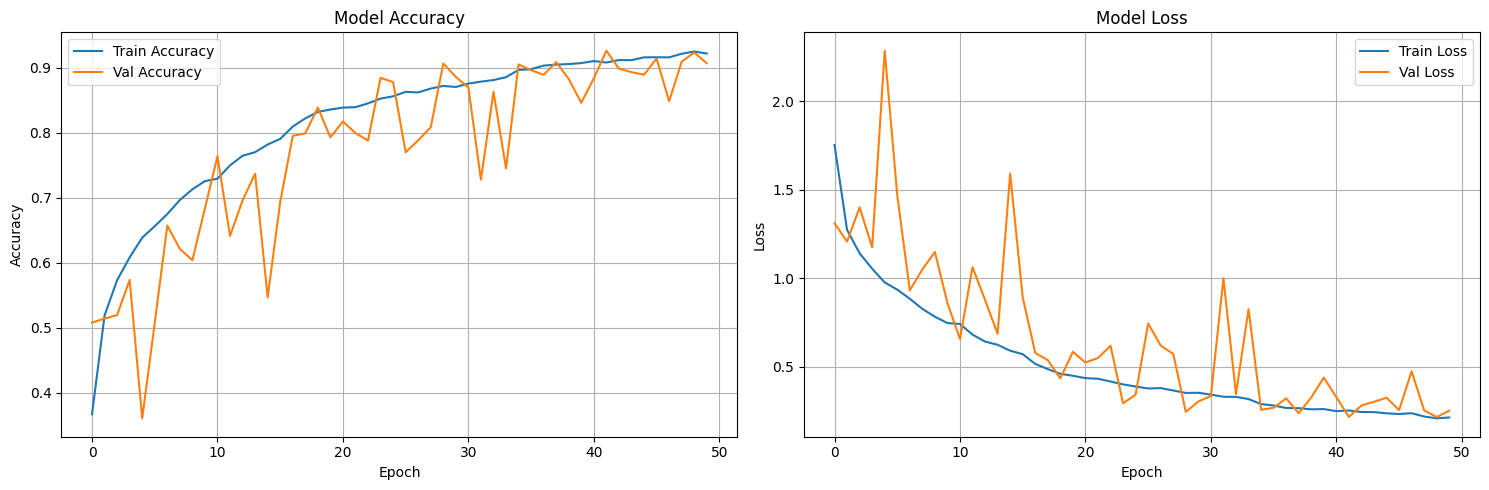

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [13]:
print("\n=== MODEL EVALUATION ===")

# Load best model
model = keras.models.load_model('best_skin_lesion_model.h5')

# Evaluate on test set
test_gen = data_generator(X_test, y_test, BATCH_SIZE, None, is_training=False)
test_steps = len(X_test) // BATCH_SIZE

test_loss, test_accuracy, test_auc = model.evaluate(test_gen, steps=test_steps)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")



=== MODEL EVALUATION ===
220/220 [==============================] - 37s 167ms/step - loss: 0.2243 - accuracy: 0.9185 - auc: 0.9944

Test Loss: 0.2243
Test Accuracy: 0.9185
Test AUC: 0.9944


W0000 00:00:1762276290.801215   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.801372   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.801468   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.801583   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.801697   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.801799   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.801911   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.802081   87845 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762276290.802225   87845 gp


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       akiec       0.99      0.96      0.97      1005
         bcc       0.99      1.00      0.99      1006
         bkl       0.91      0.82      0.86      1006
          df       0.98      0.99      0.99      1006
         mel       0.81      0.80      0.80      1006
          nv       0.77      0.86      0.81      1006
        vasc       1.00      1.00      1.00      1006

    accuracy                           0.92      7041
   macro avg       0.92      0.92      0.92      7041
weighted avg       0.92      0.92      0.92      7041



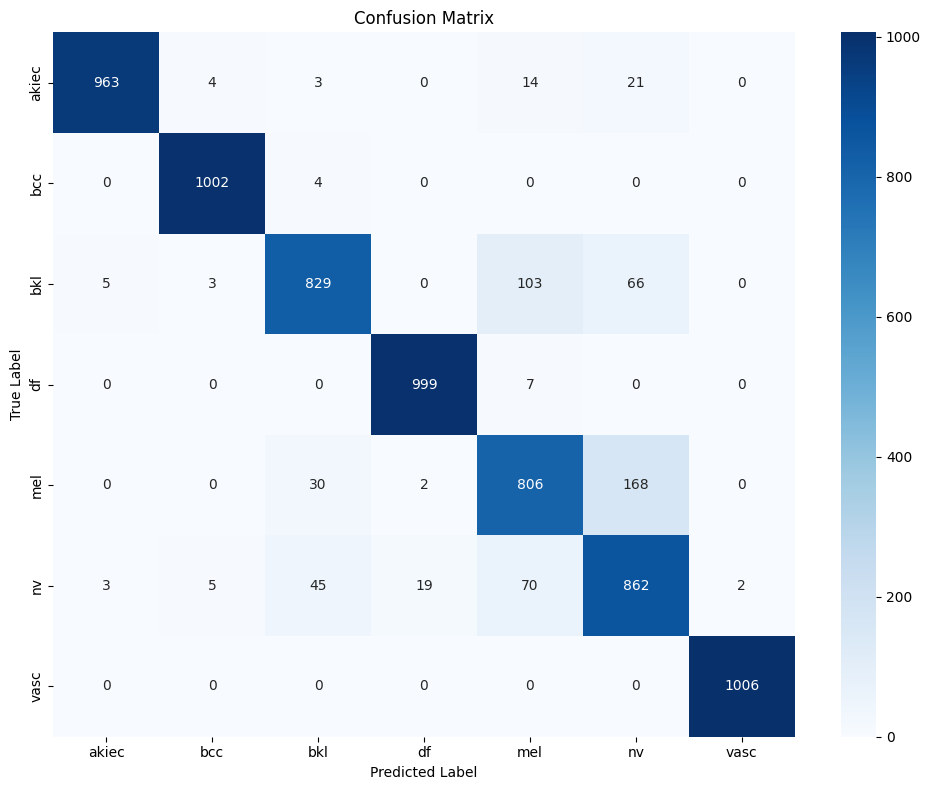

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred_probs = []
y_true = []

for i in range(0, len(X_test), BATCH_SIZE):
    batch_paths = X_test[i:i+BATCH_SIZE]
    batch_labels = y_test[i:i+BATCH_SIZE]
    
    batch_images = np.array([preprocess_image(path) for path in batch_paths])
    
    preds = model.predict(batch_images, verbose=0)
    y_pred_probs.extend(preds)
    y_true.extend(batch_labels)

y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

# Classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [15]:
# Save the model
model.save('skin_lesion_classifier_final.h5')
print("\nModel saved as 'skin_lesion_classifier_final.h5'")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved as 'label_encoder.pkl'")

# Save lesion type dictionary
with open('lesion_type_dict.pkl', 'wb') as f:
    pickle.dump(lesion_type_dict, f)
print("Lesion type dictionary saved as 'lesion_type_dict.pkl'")

print("\n=== TRAINING COMPLETE ===")
print("Files generated:")
print("1. best_skin_lesion_model.h5")
print("2. skin_lesion_classifier_final.h5")
print("3. label_encoder.pkl")
print("4. lesion_type_dict.pkl")


Model saved as 'skin_lesion_classifier_final.h5'
Label encoder saved as 'label_encoder.pkl'
Lesion type dictionary saved as 'lesion_type_dict.pkl'

=== TRAINING COMPLETE ===
Files generated:
1. best_skin_lesion_model.h5
2. skin_lesion_classifier_final.h5
3. label_encoder.pkl
4. lesion_type_dict.pkl
